In [1]:
from exif import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import cv2
import imutils

This code names the photos in a folder according to their time taken and puts them in a sorted array

In [2]:
path="images/allBlackCard/blackCard/" #Folder where images are
photos = [] #Array for filepaths
for filename in os.listdir(path):
    my_source = path + filename
    if Image(my_source).has_exif: #Checks for exif data
        my_dest = Image(my_source).datetime_original + ".jpg" #The time taken + .jpg
      
    my_dest = path + my_dest
    os.rename(my_source, my_dest) #Renames the images
    photos.append(my_dest) #Adds the filepath of the image to an array
    
photos.sort() #Sorts the array by time taken
print(photos)

['images/allBlackCard/blackCard/2023:03:20 11:57:54.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:57:59.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:05.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:09.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:13.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:18.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:22.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:27.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:31.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:35.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:40.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:44.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:51.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:58:56.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:59:01.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:59:06.jpg', 'images/allBlackCard/blackCard/2023:03:20 11:59:11.jpg', 'images/allBlackCard/blackCard

This code finds the separation between points for each photo and draws a line for visualisation

In [3]:
seps = []
freq = []
ratio = 14392.0437
density = 997
i = 140

#Finds the separation values of each pattern, as well as draws a line to visualise each plot
for filename in photos:
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (93, 93), 0)
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
    
    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    #Centre of second maxima
    M = cv2.moments(cnts[int(len(cnts)/2)]) 
    if M["m00"] != 0:
        startX = int(M["m10"] / M["m00"])
        startY = int(M["m01"] / M["m00"])
    else:
        startX = 0
        startY = 0
    
    #Centre of third maxima
    N = cv2.moments(cnts[int(len(cnts)/2) - 1])
    if N["m00"] != 0:
        endX = int(N["m10"] / N["m00"])
        endY = int(N["m01"] / N["m00"])
    else:
        endX = 0
        endY = 0
    
    #Separation using pythag 
    separation = np.sqrt((endY - startY)**2 + (endX - startX)**2)/ratio
    cv2.line(image, (startX, startY), (endX, endY), (0, 255, 0), thickness=2) #Paint line on image
    cv2.imwrite("images/allBlackCard/blackCardLines/" + str(i) + "_Line.jpeg", image) #Save image with the line
    cv2.imwrite("images/allBlackCard/grays/" + str(i) + "_gray.jpeg", thresh)
    seps.append(separation * 2) #Put separation value into array
    freq.append(i) #Appends frequency to array
    
    i += 10

print(seps)


[0.017518495455173665, 0.019185316793247167, 0.020995316846917977, 0.022250135396268075, 0.023777753089950716, 0.025027713366051495, 0.026138847857003617, 0.02683333177001658, 0.027666735296785126, 0.028500161666679836, 0.029060110764393254, 0.029893450546675086, 0.03045378051598207, 0.0311481560631935, 0.03170367078660096, 0.032675850030089944, 0.03338069950264065, 0.03449149213167637, 0.03322703758682812, 0.033504850783461756, 0.032393610158195085]


In [4]:
length = 2.583
deltaL = 0.001
deltaD = 1/ratio
hVal = 0.15
deltaH = 0.001414213562
laserLambda = 0.000000633
kval = (np.pi * hVal * pd.Series(seps))/(laserLambda * (hVal**2 + length**2))
omega = 2 * np.pi * pd.Series(freq)

deltaKfromL = (pd.Series(seps) * hVal * 2 * length) * (1/((hVal**2 + length**2)**2)) * deltaL #DeltaK from length
deltaKfromD = hVal * (1/(hVal**2 + length**2)) * deltaD #DeltaK from separations
deltaKfromH = (pd.Series(seps)) * (length**2 - hVal**2) *(1/((hVal**2 + length**2)**2)) * deltaH #DeltaK from height calc

deltaK = (np.pi/laserLambda) * (deltaKfromL + deltaKfromD + deltaKfromH) #Uncertainty in k
deltaKCube = 3*(kval ** 2) * deltaK #Uncertainty in k cube


#Remove ill-formatted data
toDrop = []
toDrop = [0, 1, 2, 3, 4, 5, 18, 19, 20]

kvalLog = kval
omegaLog = omega

for val in toDrop:
    omega = omega.drop(index = val)
    kval = kval.drop(index = val)
    deltaKCube = deltaKCube.drop(index = val)

omegasq = omega ** 2
kcube = kval ** 3
print(omegasq)

6     1.579137e+06
7     1.740998e+06
8     1.910755e+06
9     2.088408e+06
10    2.273957e+06
11    2.467401e+06
12    2.668741e+06
13    2.877977e+06
14    3.095108e+06
15    3.320135e+06
16    3.553058e+06
17    3.793876e+06
dtype: float64


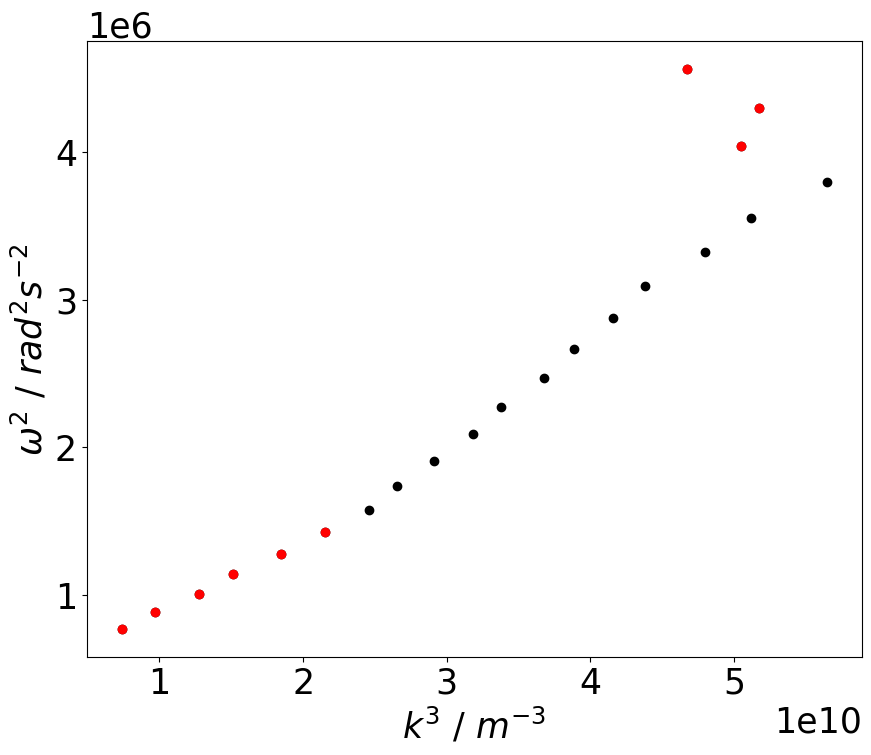

In [5]:
plt.rcParams['font.size'] = 25
figTest,  ax1 = plt.subplots(nrows=1, ncols=1, sharex=False,
                                    figsize=(10, 8))
'''
ax0.set_xlabel('$k^3$ / $m^{-3}$')
ax0.set_ylabel('${\omega}^2$ / $rad^2s^{-2}$')

ax0.scatter(kvalLog ** 3, omegaLog ** 2, c = "black")
ax0.xaxis.set_label_position("top")
ax0.xaxis.tick_top()
'''
ax1.set_xlabel('$k^3$ / $m^{-3}$')
ax1.set_ylabel('${\omega}^2$ / $rad^2s^{-2}$')

ax1.scatter(kvalLog ** 3, omegaLog ** 2, c = "black")

first6k = []
first6o = []
for i in range(0, 6):
    first6k.append(kvalLog[i] ** 3)
    first6o.append(omegaLog[i] ** 2)
    
last3k = []
last3o = []
for i in range(18, 21):
    last3k.append(kvalLog[i] ** 3)
    last3o.append(omegaLog[i] ** 2)
    
ax1.scatter(first6k, first6o, c = "red")
ax1.scatter(last3k, last3o, c = "red")
#ax1.yaxis.set_ticks(np.arange(14, 16, 1))
#ax1.xaxis.set_ticks(np.arange(23, 25, 1))
#ax1.yaxis.set_label_position("right")
#ax1.yaxis.tick_right()


72.19012052839997
max fit gradient = 71.99502673345359
min fit gradient = 66.77012449702666
0.8261295809408339


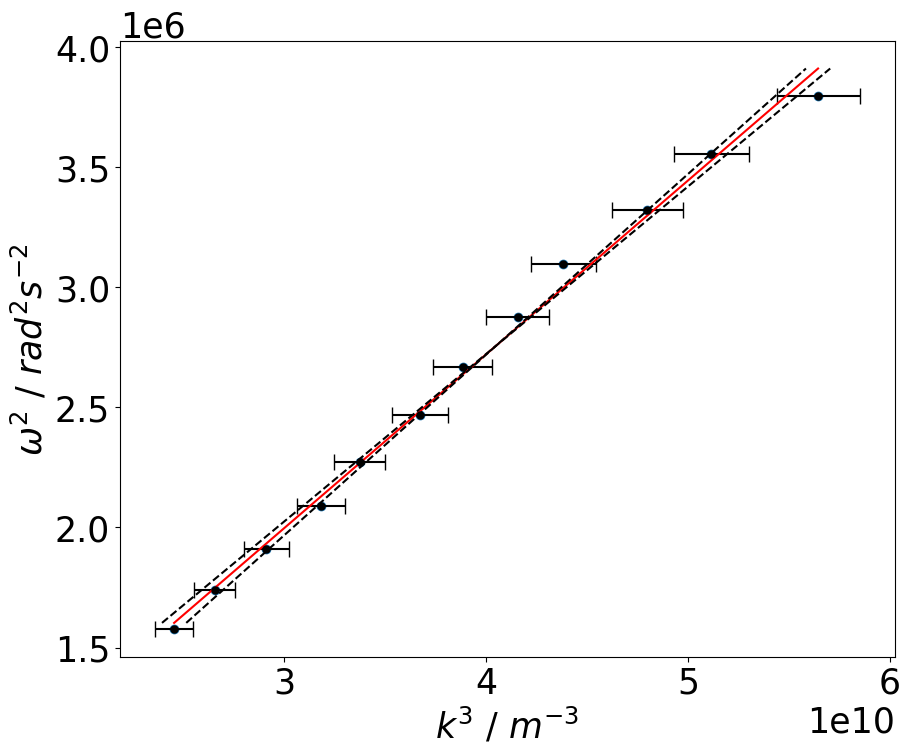

In [37]:
plt.rcParams['font.size'] = 25
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('$k^3$ / $m^{-3}$')
ax.set_ylabel('${\omega}^2$ / $rad^2s^{-2}$')

def line(x, slope, intercept):          # Set up the linear fitting - don't ammend
    return slope*x + intercept          # More set up, leave alone.

# Next few line, fits a line to the (x data, and y data) no need to change things.
popt, pcov = curve_fit(line,kcube,omegasq)
slope = popt[0]
intercept = popt[1]
err_slope = np.sqrt(float(pcov[0][0]))
err_intercept = np.sqrt(float(pcov[1][1]))

print(slope * density * 1000)
normgrad = slope * density * 1000

ax.scatter(kcube, omegasq)
ax.errorbar(kcube,           
             omegasq,
             xerr = deltaKCube,
             marker='o',             
             markersize = 5,
             markerfacecolor = 'black',
             color='black',          
             linestyle='none',       
             capsize=6,              
           )

bestFitLine = kcube * slope + intercept
ax.plot(kcube, bestFitLine, linestyle='-', color='red')



orderVal = 10 ** 10
leftVal = 0.06 * orderVal
rightVal = 0.06 * orderVal

leftX = kcube - leftVal
rightX = kcube + rightVal

#ax.plot(kcube - leftVal, bestFitLine, c = "r")
#ax.plot(kcube + rightVal, bestFitLine, c = "r")

ax.plot([leftX[6], rightX[17]], [bestFitLine[6], bestFitLine[17]], c = 'black', linestyle = '--')
ax.plot([rightX[6], leftX[17]], [bestFitLine[6], bestFitLine[17]], c = 'black', linestyle = '--')

maxgrad = (omegasq[17] - omegasq[6]) * 1000 * density / (leftX[17] - rightX[6])
mingrad = (omegasq[17] - omegasq[6]) * 1000 * density / (rightX[17] - leftX[6])


print("max fit gradient = " + str(maxgrad))
print("min fit gradient = " + str(mingrad))
print((maxgrad-mingrad)/(2 * np.sqrt(10)))


72.19012052839997


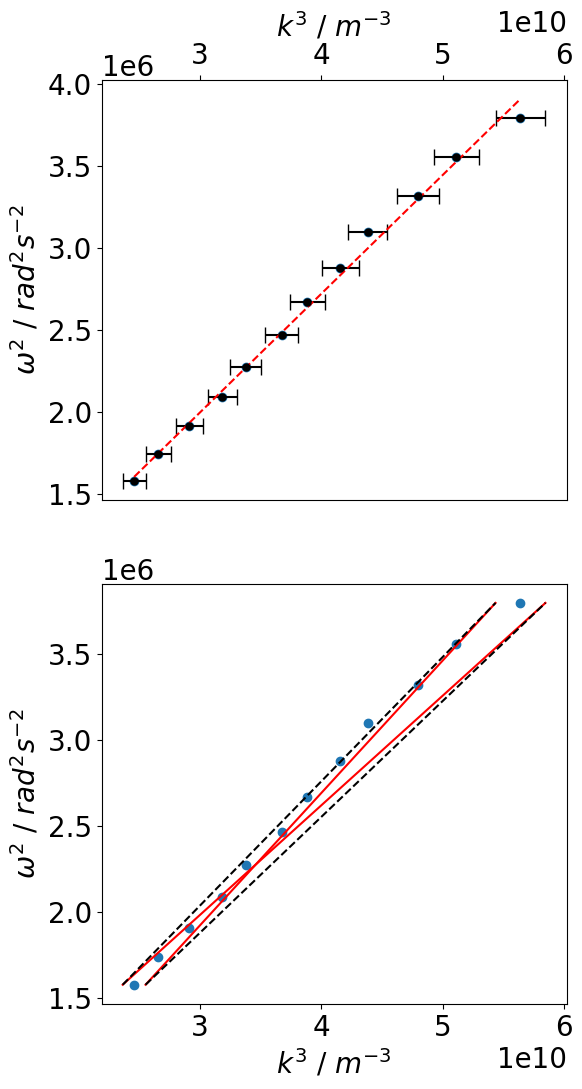

In [8]:
plt.rcParams['font.size'] = 20
figTest, (ax, ax1) = plt.subplots(nrows=2, ncols=1, sharex=False,
                                    figsize=(6, 12))

ax.set_xlabel('$k^3$ / $m^{-3}$')
ax.set_ylabel('${\omega}^2$ / $rad^2s^{-2}$')
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

ax1.set_xlabel('$k^3$ / $m^{-3}$')
ax1.set_ylabel('${\omega}^2$ / $rad^2s^{-2}$')

def line(x, slope, intercept):          # Set up the linear fitting - don't ammend
    return slope*x + intercept          # More set up, leave alone.

# Next few line, fits a line to the (x data, and y data) no need to change things.
popt, pcov = curve_fit(line,kcube,omegasq)
slope = popt[0]
intercept = popt[1]
err_slope = np.sqrt(float(pcov[0][0]))
err_intercept = np.sqrt(float(pcov[1][1]))

print(slope * density * 1000)
normgrad = slope * density * 1000

ax.scatter(kcube, omegasq)
ax.errorbar(kcube,           
             omegasq,
             xerr = deltaKCube,
             marker='o',             
             markersize = 5,
             markerfacecolor = 'black',
             color='black',          
             linestyle='none',       
             capsize=6,              
           )

ax.plot(kcube, kcube*slope+intercept, 
         linestyle='--',
         color='red')
    
ax1.scatter(kcube, omegasq)
#ax1.errorbar(kcube,           
 #            omegasq,
  #           xerr = deltaK / kval,
   #          marker='o',             
    #         markersize = 5,
     #        markerfacecolor = 'black',
      #       color='black',          
       #      linestyle='none',       
        #     capsize=6,              
         #  )

wf1 = [kcube[6] - deltaKCube[6], kcube[17] + deltaKCube[17]]
wf2 = [kcube[6] + deltaKCube[6], kcube[17] - deltaKCube[17]]

wf1p = [kcube[6] + deltaKCube[6], kcube[17] + deltaKCube[17]]
wf2p = [kcube[6] - deltaKCube[6], kcube[17] - deltaKCube[17]]

ax1.plot(wf1, [omegasq[6], omegasq[17]], c = 'red', linestyle = '-')
ax1.plot(wf2, [omegasq[6], omegasq[17]], c = 'red', linestyle = '-')

ax1.plot(wf1p, [omegasq[6], omegasq[17]], c = 'black', linestyle = '--')
ax1.plot(wf2p, [omegasq[6], omegasq[17]], c = 'black', linestyle = '--')

72.19012052839997


<ErrorbarContainer object of 3 artists>

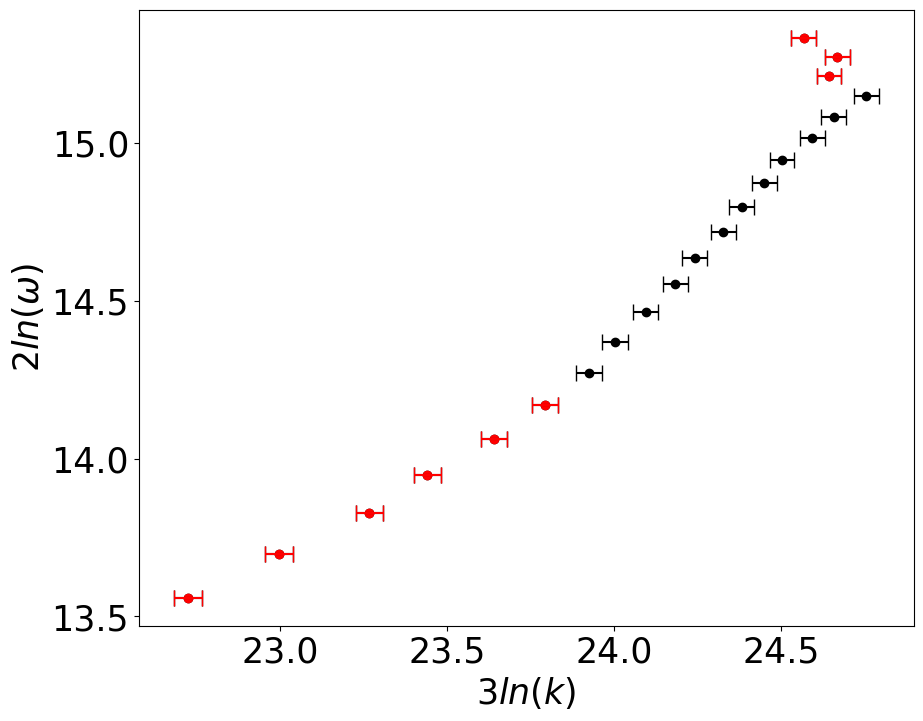

In [24]:
plt.rcParams['font.size'] = 25
fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(1, 1, 1)

ax1.set_xlabel('$3ln(k)$')
ax1.set_ylabel('$2ln(\omega)$')

def line(x, slope, intercept):          # Set up the linear fitting - don't ammend
    return slope*x + intercept          # More set up, leave alone.

# Next few line, fits a line to the (x data, and y data) no need to change things.
popt, pcov = curve_fit(line,kcube,omegasq)
slope = popt[0]
intercept = popt[1]
err_slope = np.sqrt(float(pcov[0][0]))
err_intercept = np.sqrt(float(pcov[1][1]))

print(slope * density * 1000)



ax1.scatter(3 * np.log(kvalLog), 2 * np.log(omegaLog), c = "black")

ax1.errorbar(3 * np.log(kvalLog),           
            2 * np.log(omegaLog),
             xerr = 3 * (deltaK/kvalLog),
             marker='o',             
             markersize = 0,
             markerfacecolor = 'black',
             color='black',          
             linestyle='none',       
             capsize=6,              
           )

first6k = []
first6o = []
first6kUnc = []
for i in range(0, 6):
    first6k.append(3 * np.log(kvalLog[i]))
    first6o.append(2 * np.log(omegaLog[i]))
    first6kUnc.append(3 * (deltaK[i]/kvalLog[i]))
    
last3k = []
last3o = []
last3kUnc = []
for i in range(18, 21):
    last3k.append(3 * np.log(kvalLog[i]))
    last3o.append(2 * np.log(omegaLog[i]))
    last3kUnc.append(3 * (deltaK[i]/kvalLog[i]))
    
ax1.scatter(first6k, first6o, c = "red")
ax1.scatter(last3k, last3o, c = "red")
ax1.xaxis.set_ticks(np.arange(22.5, 25, 0.5))
ax1.yaxis.set_ticks(np.arange(13.5, 15.5, 0.5))

ax1.errorbar(first6k,           
            first6o,
             xerr = first6kUnc,
             marker='o',             
             markersize = 0,
             markerfacecolor = 'red',
             color='red',          
             linestyle='none',       
             capsize=6,              
           )

ax1.errorbar(last3k,           
            last3o,
             xerr = last3kUnc,
             marker='o',             
             markersize = 0,
             markerfacecolor = 'red',
             color='red',          
             linestyle='none',       
             capsize=6,              
           )
